In [1]:
from grammar_ru.training.amenities import TRAINING_RESULTS, ResultPickleReader
from yo_fluq_ds import *


id = '20210620_113048_REP-LR10-NT10-_0127560c97824c2185c4260f77ee90f4'

res = ResultPickleReader(TRAINING_RESULTS/id)



/home/yura/anaconda3/envs/corpus/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass missing_values=nan, features=missing-only, sparse=auto, error_on_new=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<AxesSubplot:xlabel='iteration'>

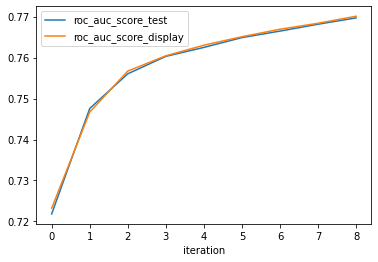

In [2]:
hdf = FileIO.read_pickle(res.get_path('output/history'))
hdf = pd.DataFrame(hdf).set_index('iteration')
hdf.drop('loss',axis=1).plot()

<AxesSubplot:xlabel='label', ylabel='predicted'>

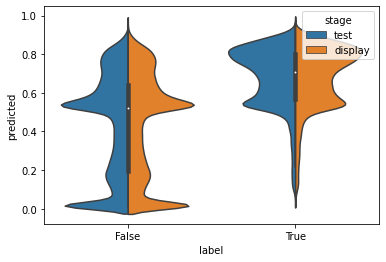

In [11]:
from seaborn import violinplot
df = FileIO.read_pickle(res.get_path('output/result_df'))
violinplot(data=df, x='label', y='predicted',split=True, hue='stage')

In [12]:
df

,word_id,file_id,match_type,another_word_id,sentence_id,paragraph_id,another_sentence_id,another_paragraph_id,delta_word_id,delta_sentence_id,delta_paragraph_id,label,priority,true,predicted,stage
163252939,163252939,e3bf0d38-dd50-45c0-986b-50eb0a65165a,simple,163252896,163252822,163252841,163252816,163252833,43,6,8,False,2.608881e-07,False,0.209581,test
163252917,163252917,e3bf0d38-dd50-45c0-986b-50eb0a65165a,normal,163252843,163252820,163252840,163252812,163252829,74,8,11,False,2.608881e-07,False,0.530257,test
163252929,163252929,e3bf0d38-dd50-45c0-986b-50eb0a65165a,normal,163252865,163252821,163252841,163252814,163252831,64,7,10,False,2.608881e-07,False,0.097905,test
163252955,163252955,e3bf0d38-dd50-45c0-986b-50eb0a65165a,normal,163252917,163252824,163252842,163252820,163252840,38,4,2,False,2.608881e-07,False,0.531454,test
163252982,163252982,e3bf0d38-dd50-45c0-986b-50eb0a65165a,normal,163252958,163252824,163252842,163252824,163252842,24,0,0,False,2.608881e-07,False,0.757222,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26108009,26108009,7b4c9493-c502-4cc0-a710-6fb681a2309d,tikhonov,26107939,26093181,26092413,26093178,26092412,70,3,1,True,4.663135e-06,True,0.858226,display
26108019,26108019,7b4c9493-c502-4cc0-a710-6fb681a2309d,normal,26108012,26093182,26092413,26093182,26092413,7,0,0,True,4.663135e-06,True,0.822479,display
26108036,26108036,7b4c9493-c502-4cc0-a710-6fb681a2309d,normal,26108000,26093183,26092413,26093181,26092413,36,2,0,True,4.663135e-06,True,0.652805,display
26108121,26108121,7b4c9493-c502-4cc0-a710-6fb681a2309d,tikhonov,26108068,26093187,26092415,26093185,26092414,53,2,1,True,4.663135e-06,True,0.848098,display


In [ ]:
Corpus.get_frames(lambda z: z.index.isin(df.file_id)).select(lambda z: df.merge(z.set_index('word_id')[[]]))

In [10]:
from grammar_ru import DfViewer
from IPython.display import HTML
from grammar_ru.training.amenities import Corpus



class SampleBuilder:
    def __init__(self, df):
        self.df = df
        
    @staticmethod
    def merge_sentences(tdf, idf):
        idf = idf.loc[idf.file_id==tdf.file_id.iloc[0]]
        idf = idf.set_index('sentence_id')[['sample_id']]
        tdf = tdf.merge(idf, left_on='sentence_id',right_index=True)
        return tdf

    def build_sample_table(self):
        idf = (Query
           .df(self.df)
           .select_many(lambda row: Query
                        .en(range(row.another_sentence_id,row.sentence_id+1))
                        .select(lambda y:dict(sample_id=row['word_id'], file_id=row['file_id'], sentence_id=y)))
           .to_dataframe()
          )



        tdf = (Corpus
               .get_frames(lambda z: z.index.isin(idf.file_id))
               .select(lambda tdf: SampleBuilder.merge_sentences(tdf,idf))
               .feed(lambda z: pd.concat(list(z)))
              )
        tdf = tdf.merge(df[['another_word_id']], left_on='sample_id', right_index=True)
        tdf['highlight'] = (tdf.word_id==tdf.sample_id) | (tdf.word_id==tdf.another_word_id)
        return tdf

    def build_html(self):
        tdf = self.build_sample_table()
        result = []
        for id in tdf.sample_id.unique():
            result.append(DfViewer(highlight_column='highlight', as_html_object = False).convert(tdf.loc[tdf.sample_id==id]))

        return HTML('<br><br>'.join(result))



AttributeError: 'DataFrame' object has no attribute 'word'

In [9]:
SampleBuilder(df.loc[(df.stage=='test') & ~df.label].sort_values('predicted').iloc[:1]).build_sample_table()

,word_id,sentence_id,word_index,word_offset,word,word_type,word_length,paragraph_id,file_id,sample_id,another_word_id,highlight
274878246,274878246,274876230,0,0,-,ru,1,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878247,274878247,274876230,1,2,Ого,ru,3,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878248,274878248,274876230,2,5,",",punct,1,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878249,274878249,274876230,3,7,то,ru,2,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878250,274878250,274876230,4,10,есть,ru,4,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878251,274878251,274876230,5,15,твоя,ru,4,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878252,274878252,274876230,6,20,кровать,ru,7,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878253,274878253,274876230,7,28,уже,ru,3,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878254,274878254,274876230,8,32,занята,ru,6,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
274878255,274878255,274876230,9,38,?,punct,1,274876160,7c69e753-7f21-4209-8543-a26d98ec27a4,274878271,274878256,False
